# **Serie multivariada**

## <span style="color:blue">Importar las librería requeridas</span>

In [ ]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

print('version de tf: ', tf.__version__)

from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam 

version de tf:  2.5.0


## <span style="color:blue">Datos - AAPL </span> 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/UN_Mineria_de_datos/Proyecto/Archivos/Datos_Sentimiento/AAPL_fin_2.csv', sep=';', header=0)

### Una primera mirada a los datos 

In [ ]:
df.head()

,post_date,numero,retweets,likes,positivo,negativo,dif_close,Indicadora,dif_std,Indicadora_2,retweetXcal
0,2015-01-02,867,2.115340,0.504037,0.239908,0.517878,-0.770000,0,-0.060877,0,0.342421
1,2015-01-05,1145,0.360699,0.517031,0.248035,0.449782,0.002501,0,0.168522,0,0.024213
2,2015-01-06,1190,0.190756,0.393277,0.288235,0.389916,0.372499,0,0.278396,0,-0.308370
3,2015-01-07,1087,0.191352,0.507820,0.261270,0.433303,1.035000,1,0.475129,1,-0.091346
4,2015-01-08,1491,0.334004,0.570758,0.335345,0.396378,0.030001,0,0.176689,0,0.038153


In [ ]:
df.describe().T 

,count,mean,std,min,25%,50%,75%,max
numero,1253.0,977.901836,603.766954,7.000000,622.000000,826.000000,1158.000000,5029.000000
retweets,1253.0,0.504838,0.318086,0.000000,0.314759,0.418902,0.588872,2.671982
likes,1253.0,1.044028,0.711237,0.142857,0.495690,0.878492,1.407643,5.200346
positivo,1253.0,0.251788,0.046768,0.000000,0.220725,0.249673,0.278632,0.571429
negativo,1253.0,0.539958,0.064412,0.166667,0.498503,0.538131,0.577812,1.000000
dif_close,1253.0,0.037829,0.621583,-3.932499,-0.212500,0.027496,0.334999,2.802502
Indicadora,1253.0,-0.003192,0.324686,-1.000000,0.000000,0.000000,0.000000,1.000000
dif_std,1253.0,0.179013,0.184583,-1.000000,0.104677,0.175945,0.267260,1.000000
Indicadora_2,1253.0,0.105347,0.307123,0.000000,0.000000,0.000000,0.000000,1.000000
retweetXcal,1252.0,-0.202271,0.266870,-0.923077,-0.369054,-0.213224,-0.050821,0.911513


In [ ]:
df.dtypes

post_date        object
numero            int64
retweets        float64
likes           float64
positivo        float64
negativo        float64
dif_close       float64
Indicadora        int64
dif_std         float64
Indicadora_2      int64
retweetXcal     float64
dtype: object

In [ ]:
df['indi_bin']=df['Indicadora'].abs()

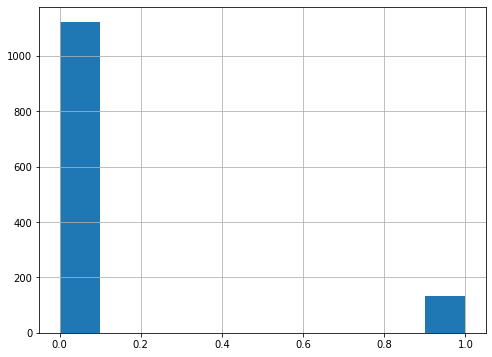

In [ ]:
df['indi_bin'].hist()

(array([-50, -49, -48, -47, -46, -45, -44, -43, -42, -41, -40, -39, -38,
        -37, -36, -35, -34, -33, -32, -31, -30, -29, -28, -27, -26, -25,
        -24, -23, -22, -21, -20, -19, -18, -17, -16, -15, -14, -13, -12,
        -11, -10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,
          2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
         15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
         41,  42,  43,  44,  45,  46,  47,  48,  49,  50]),
 array([0.70796304, 0.70504358, 0.70028399, 0.69686629, 0.70902719,
        0.70557382, 0.70124403, 0.71944694, 0.70819079, 0.70725596,
        0.71206026, 0.73048356, 0.72636233, 0.71381092, 0.71487965,
        0.74041178, 0.71493998, 0.71008082, 0.71193665, 0.72782205,
        0.73494338, 0.71671867, 0.72163031, 0.71877361, 0.75288026,
        0.73444131, 0.74170142, 0.73879401, 0.74987975, 0.73489902,
        0.73031311, 0

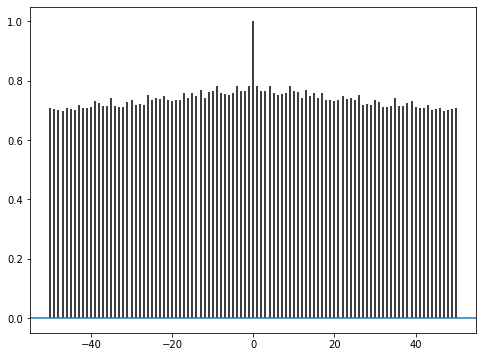

In [ ]:
# Plotting the Autocorrelation plot.
plt.acorr(df['retweets'], maxlags = 50)

[]

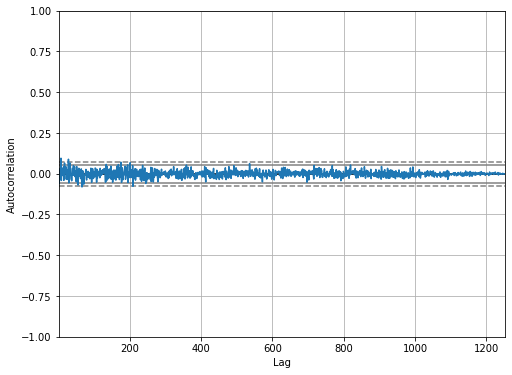

In [ ]:
# Creating Autocorrelation plot
x = pd.plotting.autocorrelation_plot(df['dif_close'])
  
# ploting the Curve
x.plot()

## <span style="color:blue">Funciones para gráficos</span>

In [ ]:
def create_time_steps(length):
  return list(range(-length, 0))

In [ ]:
def show_plot(plot_data, delta, title):
  labels = ['Historia', 'Futuro Verdadero' , 'Predicción del Modelo']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Salto de tiempo (Time-Step)')
  return plt

In [ ]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Pérdida entrenamiento')
    plt.plot(epochs, val_loss, 'r', label='Pérdida validación')
    plt.title(title)
    plt.legend()

    plt.show()

In [ ]:
def plot_serie_prediction(y_test, y_pred,rms, epochs):
    plt.plot(np.arange(0, len(y_test)), y_test, marker='.', label="verdadero")
    plt.plot(np.arange(0, len(y_test)), y_pred, marker='+', label="predicho")
    plt.xlabel('Time Step')
    plt.annotate("rms = "+str(round(rms,2)) , xy=(100, 140), size = 15)
    #plt.annotate("modelo = LSTM(50), timestep=60" , xy=(100, 146), size = 15)
    #plt.annotate("epochs=40" , xy=(100, 143), size = 15)
    plt.title("Intervalo de predicción a un día. Escala original", size = 20)
    plt.legend()
    plt.show()

## <span style="color:blue">Funciones para preparar datos de entrenamiento</span>

### Caso Univariado

In [ ]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    ''' dataset: conjunto de datos
        start_index: índice inicial de donde empezar a tomar los datos
        end_index: índice final para tomar los datos. None para tomarlos todos
        history_size: tamaño de la venytana para crear las secuencias
        target_size: dentro de cuántas observaciones futuras desea pronosticar
    '''
   
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
    
    return np.array(data), np.array(labels)

### Caso multivariado

In [ ]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    ''' dataset: conjunto de datos para las secuencias de entrada
        target:  conjunto de datos para las secuencias de salida
        start_index: índice inicial de donde empezar a tomar los datos
        end_index: índice final para tomar los datos. None para tomarlos todos
        history_size: tamaño de la venytana para crear las secuencias
        target_size: dentro de cuántas observaciones futuras desea pronosticar
        step: Cada cuántas observaciones deben tomarse. Para secuencias muy largas
              que no cambia mucho localmente
        single_step: Predecir solamente un valor futuro (=True),
                     o predecir todos los valores hasta target_size(=False)
    '''  
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

## <span style="color:blue">Pronóstico de una serie de tiempo multivariada</span>

In [241]:
print(df.shape[0])
df.shape[0]*0.25

1253


313.25

In [328]:
TRAIN_SPLIT = 1250

Se coloca una semilla para gerantizar reproductibidad

In [329]:
tf.random.set_seed(13)

In [534]:
features_considered = ['numero', 'retweets', 'likes', 'positivo','negativo']#, 

In [535]:
features = df[features_considered]
features.index = df['post_date']
features.head()

,numero,retweets,likes,positivo,negativo
post_date,,,,,
2015-01-02,867,2.115340,0.504037,0.239908,0.517878
2015-01-05,1145,0.360699,0.517031,0.248035,0.449782
2015-01-06,1190,0.190756,0.393277,0.288235,0.389916
2015-01-07,1087,0.191352,0.507820,0.261270,0.433303
2015-01-08,1491,0.334004,0.570758,0.335345,0.396378



Echemos un vistazo a cómo cada una de estas características varía con el tiempo.


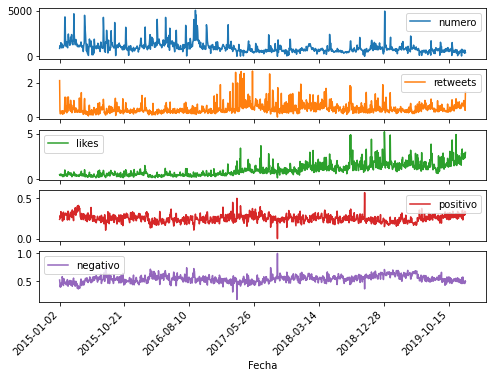

In [536]:
features.plot(subplots=True, rot=45, xlabel='Fecha')
plt.show()

Como se mencionó, el primer paso será estandarizar el conjunto de datos utilizando la media y la desviación estándar de los datos de entrenamiento.

In [537]:
#features_ind=features.reset_index()
df_indi=df[['indi_bin']].reset_index()#'indi','post_date',
#features_date=features_ind.merge(df_indi,how='left',on='post_date')

In [538]:
#fecha = features_date['post_date'].values
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [539]:
dataset = (dataset-data_mean)/data_std

In [540]:
dataset

array([[-0.18563351,  5.08031896, -0.75811692, -0.25094164, -0.34497041],
       [ 0.27483279, -0.4521108 , -0.73973905, -0.07679985, -1.40242474],
       [ 0.3493687 , -0.9879435 , -0.91477222,  0.78457391, -2.33207057],
       ...,
       [-0.48212081,  0.28958027,  2.5274669 ,  1.89622862, -1.32229272],
       [-0.99227772, -0.35308507,  1.84903998,  1.03665645, -0.54086045],
       [-0.95749429,  3.02612324,  2.68039903,  1.60839978, -0.75812994]])

In [541]:
dataset=np.array(np.concatenate( (dataset,df_indi.iloc[:,1:2]),axis = 1),dtype='float')
#features_date.iloc[:,1:6].values
#dataset
#features_date

In [542]:
# Cuenta las frecuencias de los datos
counts = np.bincount(df_indi.iloc[:,1])
print(
    "Number of positive samples in training data: {} ({:.2f}% of total)".format(
        counts[1], 100 * float(counts[1]) / len(df_indi.iloc[:,1])
    )
)

# Crea los pesos para el entrenamiento. Más peso a los menos frecuentes (1)
weight_for_0 = 1.0 / counts[0]
weight_for_1 = 1.0 / counts[1]

Number of positive samples in training data: 132 (10.53% of total)


In [543]:
print(weight_for_1)
print(weight_for_0)

0.007575757575757576
0.0008920606601248885


## <span style="color:blue">Modelo de un Paso</span>


En una configuración de un  paso, el modelo aprende a predecir un solo punto en el futuro en función del historial proporcionado.

La función a continuación realiza la misma tarea de ventanas que antes, sin embargo, aquí muestra la observación pasada en función del tamaño de paso dado.

### Crea arreglos de datos de entrenamiento y validación

In [549]:
past_history = 7
future_target = 1
STEP = 1
target = 5

x_train_single, y_train_single = multivariate_data(dataset[:,0:5], dataset[:, target], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
TRAIN_SPLIT2 = 950
x_val_single, y_val_single = multivariate_data(dataset[:,0:5], dataset[:, target],
                                               TRAIN_SPLIT2, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [550]:
print(dataset.shape)
print(x_train_single.shape)
print(y_train_single.shape)
print(x_val_single.shape)
print(y_val_single.shape)

(1253, 6)
(1243, 7, 5)
(1243,)
(295, 7, 5)
(295,)


Veamos una ventana de datos de la historia pasada

In [551]:
print ('Ventana ejemplo de la historia pasada : {}'.format(x_train_single[0].shape))

Ventana ejemplo de la historia pasada : (7, 5)


In [552]:
y_train_single[0:10]

array([0., 0., 0., 0., 0., 0., 0., 1., 1., 0.])

### Crea objetos tf.data.Dataset para entreno y validación

Para manejo más eficiente de memoria 

In [553]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000

train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

### Modelo LSTM 

In [554]:
# Build the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Embedding
from sklearn.metrics import confusion_matrix

In [566]:
input_shape = (x_train_single.shape[1], x_train_single.shape[2])
units = 64
drop_out_rate = 0.0001

# layers
inputs = Input(input_shape)
x = Dropout(drop_out_rate/2, name= 'Dropout_01')(inputs)
x = LSTM(units=units, name='LSTM_layer',
         dropout=drop_out_rate/2, recurrent_dropout=0.2, activation='tanh',return_sequences =True)(x)        # 
x = Dropout(drop_out_rate/4, name= 'Dropout_02')(x)
x = LSTM(units=units//2, name='LSTM_layer2',
         dropout=drop_out_rate/4, recurrent_dropout=0.2, activation='tanh',return_sequences =True)(x)
x = Dropout(drop_out_rate/6, name= 'Dropout_03')(x)         
x = LSTM(units=units//4, name='LSTM_layer3',
         dropout=drop_out_rate/6, recurrent_dropout=0.1, activation='tanh')(x)     #      
x = Dense(1, activation='tanh')(x)
outputs = Dense(1)(x)

# model
single_step_model = Model(inputs=inputs, outputs=outputs, name='series_LSTM_model')
single_step_model.summary()


#single_step_model = tf.keras.models.Sequential()
#single_step_model.add(tf.keras.layers.LSTM(32, input_shape=x_train_single.shape[-2:]))
#single_step_model.add(tf.keras.layers.Dense(1))

Model: "series_LSTM_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_70 (InputLayer)        [(None, 7, 5)]            0         
_________________________________________________________________
Dropout_01 (Dropout)         (None, 7, 5)              0         
_________________________________________________________________
LSTM_layer (LSTM)            (None, 7, 64)             17920     
_________________________________________________________________
Dropout_02 (Dropout)         (None, 7, 64)             0         
_________________________________________________________________
LSTM_layer2 (LSTM)           (None, 7, 32)             12416     
_________________________________________________________________
Dropout_03 (Dropout)         (None, 7, 32)             0         
_________________________________________________________________
LSTM_layer3 (LSTM)           (None, 16)          

### Compila

In [567]:
single_step_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

Revisemos una predicción simple

In [296]:
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

(64, 1)


In [60]:
#single_step_model.predict(x).T
?single_step_model.fit

In [275]:
counts

array([1121,  132])

### Entrena

In [568]:
EVALUATION_INTERVAL = 200
EPOCHS = 70
class_weight = {0: weight_for_0, 1: weight_for_1}
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=10,shuffle=True,class_weight=class_weight) #

Epoch 1/70
200/200 [==============================] - 11s 27ms/step - loss: 0.0012 - accuracy: 0.6772 - val_loss: 1.0313 - val_accuracy: 0.2508
Epoch 2/70
200/200 [==============================] - 5s 24ms/step - loss: 9.1083e-04 - accuracy: 0.6507 - val_loss: 1.0216 - val_accuracy: 0.2339
Epoch 3/70
200/200 [==============================] - 5s 24ms/step - loss: 8.8801e-04 - accuracy: 0.6690 - val_loss: 1.0134 - val_accuracy: 0.2373
Epoch 4/70
200/200 [==============================] - 5s 23ms/step - loss: 8.7003e-04 - accuracy: 0.6837 - val_loss: 1.0554 - val_accuracy: 0.2746
Epoch 5/70
200/200 [==============================] - 5s 24ms/step - loss: 8.4984e-04 - accuracy: 0.6884 - val_loss: 0.9623 - val_accuracy: 0.3017
Epoch 6/70
200/200 [==============================] - 5s 24ms/step - loss: 8.2869e-04 - accuracy: 0.6938 - val_loss: 0.9982 - val_accuracy: 0.3085
Epoch 7/70
200/200 [==============================] - 5s 23ms/step - loss: 8.0153e-04 - accuracy: 0.7000 - val_loss: 0.97

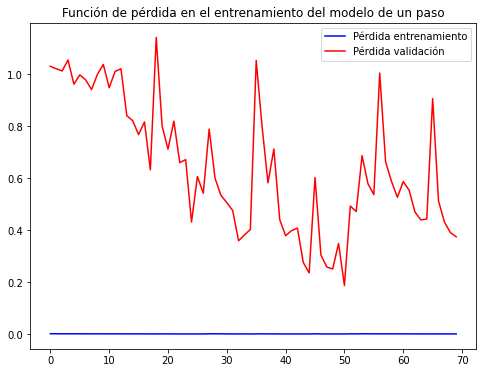

In [569]:
plot_train_history(single_step_history,
                   'Función de pérdida en el entrenamiento del modelo de un paso')

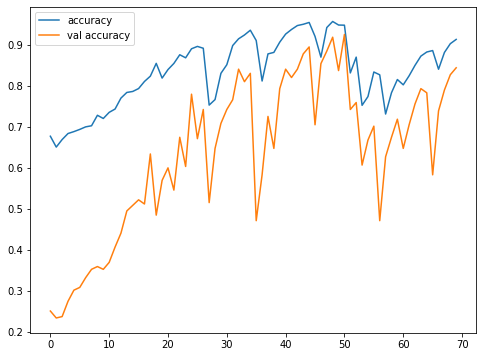

In [570]:
from matplotlib import pyplot as plt

plt.plot(single_step_history.history['accuracy'], label='accuracy')
plt.plot(single_step_history.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.show()

## <span style="color:blue">Predicciones</span>

In [70]:
y_val_single

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0.

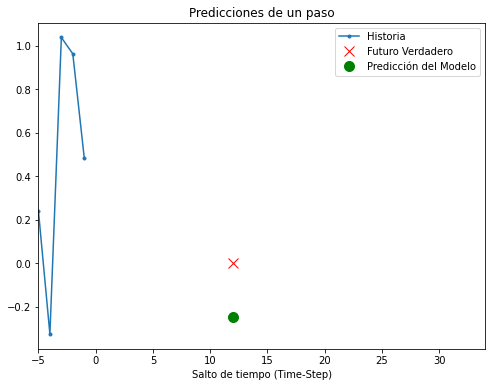

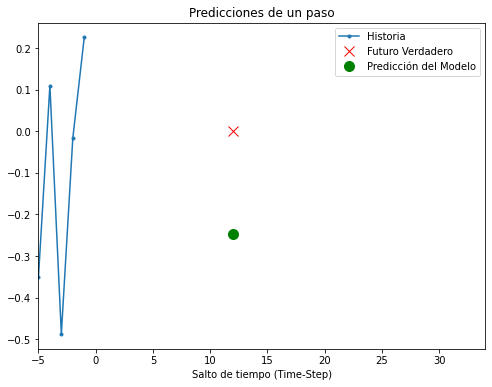

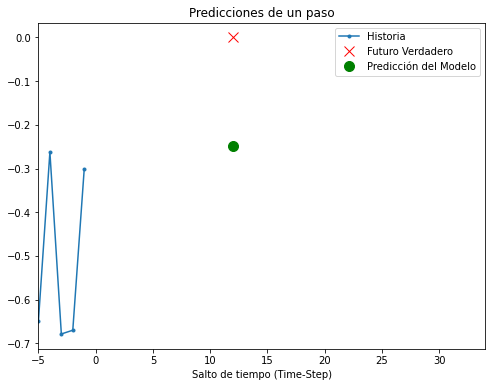

In [134]:
for x, y in val_data_single.take(3):
    plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Predicciones de un paso')
    plot.show()

In [ ]:
y_pred =[]

for x, y in val_data_single:
    pred = single_step_model.predict(x)
    
    plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Predicciones de un paso')
    plot.show()


In [571]:
y_pred = single_step_model.predict(x_val_single)
y_pred = np.squeeze(y_pred,axis=1)
y_test = y_val_single

In [561]:
print(y_pred.shape)
print(y_test.shape)

(295,)
(295,)


In [572]:
# Predicting the Test set results
y_pred[y_pred > 0.5] = 1
y_pred[y_pred <=0.5] = 0
print((y_pred == 0).sum())
print((y_pred == 1).sum())

180
115


In [573]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[180,  46],
       [  0,  69]])

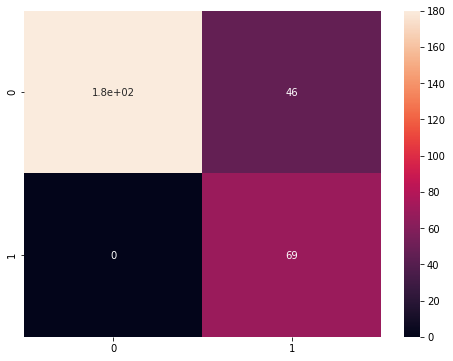

In [574]:
import seaborn as sns
sns.heatmap(cm,annot=True)

In [575]:
single_step_model.save('/content/drive/MyDrive/Colab Notebooks/UN_Mineria_de_datos/Proyecto/Archivos/Datos_Sentimiento/modelo_1.h5')

In [522]:
keras.experimental.export_saved_model(single_step_model,'/content/drive/MyDrive/Colab Notebooks/UN_Mineria_de_datos/Proyecto/Archivos/Datos_Sentimiento')

NameError: ignored

### rms

In [ ]:
#rmsLSTM = np.sqrt(np.mean(np.power(y_pred-y_test,2)))
#print(rmsLSTM )

0.5169201850699908


In [ ]:
def plot_series(y_test,y_pred, title, x_label, y_label,epochs):
    plt.plot(np.arange(0, len(y_test)), y_test, marker='.', label="verdadero")
    plt.plot(np.arange(0, len(y_test)), y_pred, marker='+', label="predicho")
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    #plt.annotate("rms="+str(round(rms,2)) , xy=(500, 1.3), size = 10)
    #plt.annotate("modelo = LSTM(50), timestep=60" , xy=(100, 146), size = 15)
    #
    plt.annotate("epochs="+str(epochs) , xy=(500, 1.5), size = 10)
    plt.title(title)
    plt.legend()
    plt.show()
    


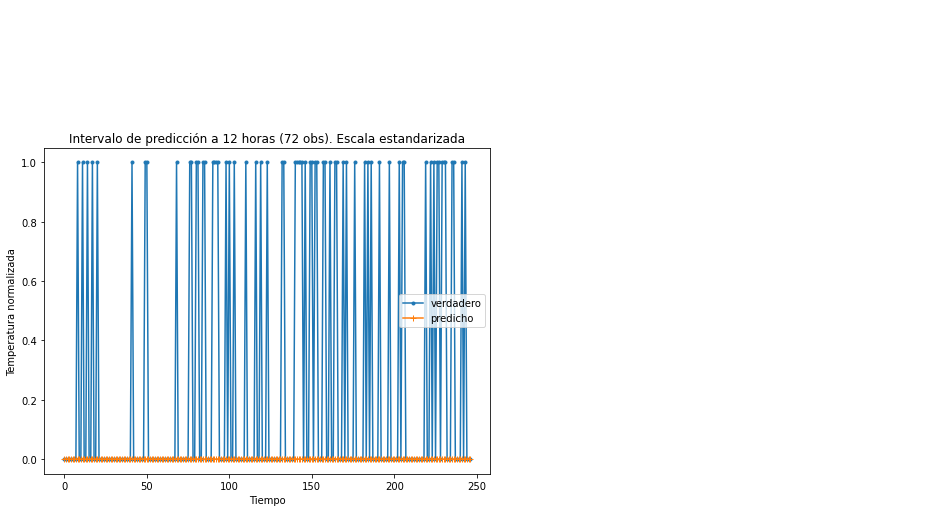

In [ ]:
title = "Intervalo de predicción a 12 horas (72 obs). Escala estandarizada"
x_label = 'Tiempo'
y_label = 'Temperatura normalizada'
rms = rmsLSTM
plot_series(y_test[:2000], y_pred[:2000],title,x_label, y_label, epochs=10 )